In [1]:
import dataloader
import random
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import torch

In [2]:
raw_dataset = dataloader.get_dataset(None, 8192)
print({ k: len(v) for k, v in raw_dataset.items() })

{'BackgroundSounds': 8192, 'Whistling': 22, 'Horn': 1146, 'Train': 895, 'Clapping': 546, 'Laughing': 216, 'Whistle': 21, 'Dog': 2768, 'Noise': 1950, 'BirdChirp': 1299, 'Siren': 2363, 'Scream': 36, 'Rooster': 402, 'Aircraft': 1119, 'Crow': 621, 'Sneezing': 154, 'Gunshot': 8, 'Wind': 1408, 'Frog': 3608, 'CarDoor': 452, 'Engine': 5845, 'VehicleExhaust': 292, 'Coughing': 736, 'Cat': 242, 'Beeping': 98, 'Thunder': 488, 'Bell': 702, 'Unknown': 293, 'Insects': 1986, 'Sheep': 191, 'Basketball': 752, 'Drums': 6193, 'Cow': 168, 'GunNoise': 2448, 'PowerTool': 1537, 'GlassBreak': 982, 'Skateboarding': 76, 'Jackhammer': 2882, 'HandSaw': 332}


spectrum min 5.3204094e-13
spectrum max 6.8591844e-06
spectrum mean 1.2764727e-07
spectrum std 4.6335091e-07

spectrum params (6.7532735, -5.9188664e-05)


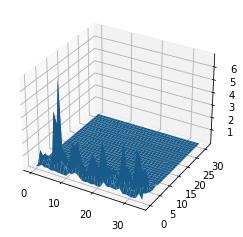

In [8]:
def get_spectrum(sample):
    assert sample.shape == (8000,)

    sample_offset = np.mean(sample)
    sample = sample - sample_offset

    sample_scale = np.sqrt(np.sum(sample**2))
    if sample_scale <= 0:
        sample_scale = 1
    sample = sample / sample_scale

    f, t, Sxx = sig.spectrogram(sample, dataloader.UNIFORM_SAMPLE_RATE)
    
    mean_size = (4, 1)
    mean_k = torch.ones(mean_size).cuda()
    res = torch.nn.functional.conv2d(torch.tensor(Sxx).cuda().reshape(1, 1, *Sxx.shape), mean_k.reshape(1, 1, *mean_size), stride = mean_size)
    res = np.array(res.reshape(*res.shape[2:]).cpu())
    
    return res, (sample_scale, sample_offset)

sample = random.choice(random.choice(list(raw_dataset.values())))
spectrum, spectrum_params = get_spectrum(sample)

print('spectrum min', np.min(spectrum))
print('spectrum max', np.max(spectrum))
print('spectrum mean', np.mean(spectrum))
print('spectrum std', np.std(spectrum))

print()
print('spectrum params', spectrum_params)

def plot3d(spectrum):
    assert len(spectrum.shape) == 2
    fig = plt.figure()
    p = fig.add_subplot(111, projection='3d')
    x, y = np.meshgrid(range(spectrum.shape[1]), range(spectrum.shape[0]))
    p.plot_surface(x, y, spectrum)
    plt.show()
plot3d(spectrum)

2.3596062419528607e-06


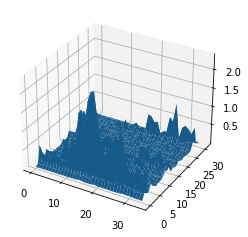

new point [2, 17, 2.0671377569669858e-05]
1.6096701074275188e-06


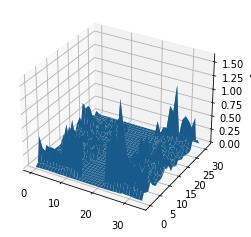

new point [2, 26, 2.0636878616642207e-05]
9.894425829770626e-07


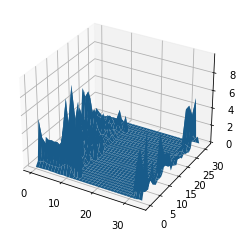

new point [2, 11, 1.4605597243644297e-05]
7.461158020305447e-07


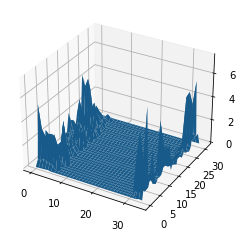

new point [23, 1, 9.676433364802506e-06]
7.461158020305447e-07


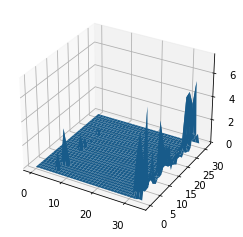

new point [28, 33, 1.2035447980451863e-05]
3.0411797524720896e-07


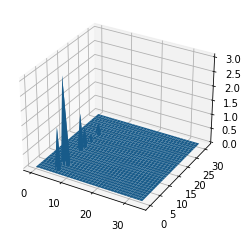

new point [5, 6, 1.1918844393221661e-05]
0.0


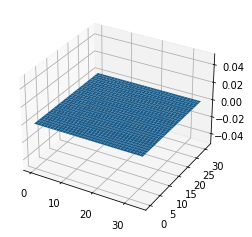

new point [0, 0, 7.661457857466303e-06]
0.0


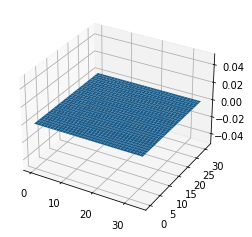

new point [0, 0, 7.661457857466303e-06]
0.0


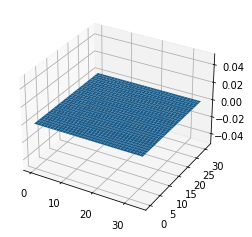

array([[2.00000000e+00, 1.70000000e+01, 2.06713776e-05],
       [2.00000000e+00, 2.60000000e+01, 2.06368786e-05],
       [2.00000000e+00, 1.10000000e+01, 1.46055972e-05],
       [2.30000000e+01, 1.00000000e+00, 9.67643336e-06],
       [2.80000000e+01, 3.30000000e+01, 1.20354480e-05],
       [5.00000000e+00, 6.00000000e+00, 1.19188444e-05],
       [0.00000000e+00, 0.00000000e+00, 7.66145786e-06],
       [0.00000000e+00, 0.00000000e+00, 7.66145786e-06]])

In [422]:
def decompose_gaussians(spectrum, variances, *, log = False):
    assert len(spectrum.shape) == 2
    spectrum = torch.tensor(spectrum).cuda()
    
    res = []

    if log:
        print(torch.max(spectrum).item())
        plot3d(np.array(spectrum.cpu()))

    orig_spectrum = spectrum
    zero = torch.tensor([0]).cuda()
        
    for variance in variances:
        r = [round(min(2 * variance, dim - 1)) for dim in spectrum.shape]
        x, y = torch.meshgrid(torch.tensor(range(-r[0], r[0] + 1)).cuda(), torch.tensor(range(-r[1], r[1] + 1)).cuda())
        g = torch.exp(-(x**2 + y**2) / variance)
        e = torch.nn.functional.conv2d(spectrum.reshape(1, 1, *spectrum.shape), g.reshape(1, 1, *g.shape), padding = 'same').reshape(spectrum.shape)
        assert spectrum.shape == e.shape, f'{spectrum.shape} -> {e.shape}'
        p = np.unravel_index(torch.argmax(e).item(), e.shape)
        assert len(p) == 2, f'{p}'
        x, y = torch.meshgrid(torch.tensor(range(spectrum.shape[0])).cuda(), torch.tensor(range(spectrum.shape[1])).cuda())
        assert x.shape == y.shape == spectrum.shape
        
#         mask = torch.exp(-((x-p[0])**2 + (y-p[1])**2) / variance)
        mask = torch.exp(-(y-p[1])**2 / variance)
        
#         m = e[p]
        m = torch.sum(orig_spectrum * mask)
        
        res.append([*p, m.item()])
        
        spectrum = torch.maximum(spectrum - m * mask, zero)
#         spectrum = spectrum - m * mask
        
        if log:
            print('new point', res[-1])
            print(torch.max(spectrum).item())
            plot3d(np.array(spectrum.cpu()))

    return np.array(res)

decompose_gaussians(spectrum, [5] * 8, log = True)

In [423]:
GAUSSIANS = 8
VARIANCE = 5

def prep_sample(x):
    spectrum, _ = get_spectrum(x)
    points = decompose_gaussians(spectrum, [VARIANCE] * GAUSSIANS) / np.array([*spectrum.shape, 1])
    assert points.shape == (GAUSSIANS, 3)
    
    t = np.sum(points[:,2])
    if t > 0:
        points[:,1] -= np.sum(points[:,1] * points[:,2]) / t
        e = np.exp(points[:,2])
        points[:,2] = e / np.sum(e)
    
    return points

count = [0]
total = sum([len(v) for k, v in raw_dataset.items()])
def logging_prep_sample(x):
    count[0] += 1
    print(f'\rprocessing samples: {count[0]}/{total} ({100 * count[0] / total:0.2f}%)                         ', end = '')
    return prep_sample(x)

print(f'prepping data with GUASSIANS={GAUSSIANS}, VARIANCE={VARIANCE}')
dataset = { k: [logging_prep_sample(x) for x in v] for k, v in raw_dataset.items() }
print()
print({ k: len(v) for k, v in dataset.items() })

prepping data with GUASSIANS=8, VARIANCE=5
processing samples: 53469/53469 (100.00%)                         
{'Train': 895, 'Clapping': 546, 'BackgroundSounds': 8192, 'Laughing': 216, 'Whistle': 21, 'Whistling': 22, 'Horn': 1146, 'Dog': 2768, 'Siren': 2363, 'BirdChirp': 1299, 'Noise': 1950, 'Scream': 36, 'Aircraft': 1119, 'Crow': 621, 'Sneezing': 154, 'Rooster': 402, 'Wind': 1408, 'Gunshot': 8, 'Frog': 3608, 'CarDoor': 452, 'Engine': 5845, 'VehicleExhaust': 292, 'Coughing': 736, 'Cat': 242, 'Bell': 702, 'Beeping': 98, 'Thunder': 488, 'Unknown': 293, 'Insects': 1986, 'Sheep': 191, 'Basketball': 752, 'Drums': 6193, 'Cow': 168, 'GunNoise': 2448, 'PowerTool': 1537, 'GlassBreak': 982, 'Skateboarding': 76, 'Jackhammer': 2882, 'HandSaw': 332}


In [457]:
classes = 28
benchmark_dataset = dict(random.sample([(k,v) for k,v in dataset.items() if len(v) >= 256], classes))
print({ k: len(v) for k, v in benchmark_dataset.items() })
max_clusters = 32

def benchmark(filter_class, **args):
    print(f'bench: {filter_class.__name__}')
    print()
    print('heterogeneous class tests:')
    vals = []
    for i in range(8):
        f = filter_class(max_clusters, **args)
        keeps = []
        reps = 30
        for rep in range(reps):
            for label, samples in benchmark_dataset.items():
                if f.insert(random.choice(samples)):
                    keeps.append(label)
        vals.append(100 * len(keeps) / len(benchmark_dataset) / reps)
        print(f'iter {i:>4}: kept {len(keeps)}/{len(benchmark_dataset) * reps} ({vals[-1]:.2f}%)')
    print(f'mean: {np.mean(vals):>5.2f} std: {np.std(vals):>5.2f} med: {np.median(vals):>5.2f}')

    print()
    print('homogenous class tests:')
    vals = []
    for label, samples in benchmark_dataset.items():
        f = filter_class(max_clusters, **args)
        keeps = []
        reps = 300
        for rep in range(reps):
            if f.insert(random.choice(samples)):
                keeps.append(i)
        vals.append(100 * len(keeps) / reps)
        print(f'{label:>16}: kept {len(keeps):>4}/{reps} ({vals[-1]:>5.2f}%)')
    print(f'mean: {np.mean(vals):>5.2f} std: {np.std(vals):>5.2f}')

dm_grids = np.meshgrid(range(GAUSSIANS), range(GAUSSIANS), indexing = 'ij')
def distance_metric(a, b):
    assert a.shape == (GAUSSIANS, 3)
    assert b.shape == (GAUSSIANS, 3)
    
    w = np.array([0.00001, 1, 1])
    a = a * w
    b = b * w
    
    def one_side(a, b):
        i, j = dm_grids
#         return np.sum(a[:,-1] * np.min(np.sum((a[:,:-1][i] - b[:,:-1][j])**2, axis = -1), axis = 0))
        return np.mean(np.min(np.sum((a[i] - b[j])**2, axis = -1), axis = 0), axis = 0)

    return (one_side(a, b) + one_side(b, a))

class ClusterFilter:
    def __init__(self, max_clusters, *, thresh, max_weight, weight_decay):
        self.embeds = np.zeros((max_clusters, GAUSSIANS, 3)) + np.array([np.inf, np.inf, 1 / GAUSSIANS])
        self.weights = np.zeros((max_clusters,))
        self.max_clusters = max_clusters
        self.base_radius = thresh
        self.max_weight = max_weight
        self.weight_decay = weight_decay
    def insert(self, embed):
        assert embed.shape == self.embeds.shape[1:] and self.embeds.shape[0] == self.max_clusters and self.weights.shape == (self.max_clusters,)
        dists = np.array([distance_metric(x, embed) for x in self.embeds])
        assert dists.shape == (self.max_clusters,), f'{dists.shape} != {(self.max_clusters,)}'

        close = dists <= self.weights**1 * self.base_radius
        
        if np.any(close):
            self.embeds = np.concatenate([
                self.embeds[~close],
                self.embeds[close],
            ])
            self.weights = np.concatenate([
                np.maximum(self.weights[~close] * self.weight_decay, 1),
                np.minimum(self.weights[close] + 1, self.max_weight),
            ])

            return False
        else:
            self.embeds = np.concatenate([
                self.embeds[1:],
                [ embed ],
            ])
            self.weights = np.concatenate([
                np.maximum(self.weights[1:] * self.weight_decay, 1),
                [ 1 ],
            ])
            return True

benchmark(ClusterFilter, thresh = 0.0008, max_weight = 128, weight_decay = 0.95)

{'Coughing': 736, 'Drums': 6193, 'Frog': 3608, 'Unknown': 293, 'HandSaw': 332, 'VehicleExhaust': 292, 'BackgroundSounds': 8192, 'Siren': 2363, 'Bell': 702, 'Horn': 1146, 'Rooster': 402, 'Jackhammer': 2882, 'Crow': 621, 'CarDoor': 452, 'BirdChirp': 1299, 'Wind': 1408, 'GunNoise': 2448, 'PowerTool': 1537, 'Dog': 2768, 'Thunder': 488, 'Insects': 1986, 'Train': 895, 'Aircraft': 1119, 'Clapping': 546, 'GlassBreak': 982, 'Engine': 5845, 'Noise': 1950, 'Basketball': 752}
bench: ClusterFilter

heterogeneous class tests:
iter    0: kept 806/840 (95.95%)
iter    1: kept 806/840 (95.95%)
iter    2: kept 810/840 (96.43%)
iter    3: kept 814/840 (96.90%)
iter    4: kept 797/840 (94.88%)
iter    5: kept 811/840 (96.55%)
iter    6: kept 800/840 (95.24%)
iter    7: kept 807/840 (96.07%)
mean: 96.00 std:  0.63 med: 96.01

homogenous class tests:
        Coughing: kept  281/300 (93.67%)
           Drums: kept  154/300 (51.33%)
            Frog: kept  282/300 (94.00%)
         Unknown: kept  204/300 (68.